# Mangrove Analysis  

## Global Mangrove Watch Data
[Global Mangrove Watch (GMW)](https://www.globalmangrovewatch.org/) is an initiative to track global mangrove extents. It uses combined ALOS PALSAR and Landsat (optical) data to form a baseline shapefile for the year 2010. More detailed information on the initiative can be found [here](http://data.unep-wcmc.org/datasets/45). To summarize, GMW shapefiles provide a general location of all mangroves in the world.

The shapefile used by this notebook is a country specific extraction from the global shapefile provided by GMW. The purpose of this notebook is to use the extracted shapefile as a baseline for classifying mangroves through NDVI thresholding. We then analyze how the mangroves change over time in our area of interest.

---
## Analysis Process
The process begins with retrieving data for a specific area in a time series. This dataset is then compressed into a mean composite for each year. From the mean composite, we then calculate the NDVI values of each pixel in each year. The dataset is then masked, and the NDVI threshold is applied for mangrove classification. The following image shows the decision tree for the classification.

![mangrove_decision_tree.png](mangrove_decision_tree.png)


After classification, we can perform a variety of analyses on the data. We can estimate the change in mangrove areas by counting all the classified pixels for each year and plotting the trend line of the count. We can also visualize the mangrove areas by plotting each classified pixel a certain color. 

## Define Options Here
Areas and times of interest are included as examples.

## Imports

In [1]:
%matplotlib inline

from sys import path
path.append("../")

import datacube
import fiona
import functools as ft
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
import seaborn as sns
import xarray as xr

import geopandas as gpd
from datacube.utils import geometry

from matplotlib.ticker import MaxNLocator
from shapely.geometry import shape

from odc.ui import with_ui_cbk
from odc.algo import to_f32, from_float, xr_geomedian
# from utils.data_cube_utilities.dc_mosaic import create_mean_mosaic
# from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa
# from utils.data_cube_utilities.dc_mosaic import ls7_unpack_qa
# from utils.data_cube_utilities.dc_mosaic import ls5_unpack_qa
# from utils.data_cube_utilities.dc_rgb import rgb
import sys
sys.path.append('../Scripts')

import warnings
warnings.filterwarnings("ignore")

from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import display_map, rgb, map_shapefile
from deafrica_bandindices import calculate_indices
from deafrica_dask import create_local_dask_cluster

from deafrica_spatialtools import xr_rasterize
from deafrica_classificationtools import HiddenPrints

## Load the Data
This method loads the data from the Open Datacube using the defined options above.

## Mean Mosaic
This object will create the mean temporal composite for each year in the dataset.

## Create Mask
The following method loads a shapefile and extracts a mask from it. This mask will form the baseline of our classification using an NDVI threshold.

## Features
The following methods will be the features we build for our classification.


### NDVI

NDVI is used for mangrove classification within the mangrove mask.


$$ NDVI = \frac{NIR - Red}{NIR + Red} $$



### NDWI

NDWI is used for creating a better greyscale image when displaying the results.


$$ NDWI = \frac{Green - NIR}{Green + NIR} $$

## Classification
The MangroveClassifier object is used for building features and classifying mangroves based on a given threshold.

## Get Mangrove Pixel Counts
This method calculates the count of each mangrove classification for each year in a given dataset. This provides information on the area of the mangroves for each year.

---
# Results
The following section holds the results of running the code above.

## Loading the Data

In [2]:
# dataset = load_dc_data(PLATFORM, PRODUCT, LATITUDE, LONGITUDE, YEARS)
dc = datacube.Datacube(app='Mangrove')

create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:43951 Dashboard: /user/nanaboamah/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [3]:
lat = -6.1367
lon = 39.1751

# lat = -4.1
# lon = 39.5

buffer = 0.1

query = {
   #'y': (-6.2006, -6.1099), #, (lon-buffer, lon+buffer),
   #'x': (39.4090, 39.5213), #(lat+buffer, lat-buffer),
    'group_by': 'solar_day',
    'resolution': (-30, 30),
    'align': (15, 15),
}

output_crs = mostcommon_crs(dc=dc, product='ls8_usgs_sr_scene', query=query)

In [4]:
vector_file = 'mangrove/chwaka_mangrove.shp'
attribute_col = 'FID'
#read shapefile
gdf = gpd.read_file(vector_file)


In [5]:
map_shapefile(gdf, attribute=attribute_col)

Label(value='')

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

In [6]:
def cal_loaddataset(time_ds):
    
    geom = geometry.Geometry(gdf.iloc[0].geometry.__geo_interface__,
                         geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))
    
    print(time_ds)

    query['time'] = time_ds
    query['geopolygon'] = geom
    # Load landsat (hide print statements)
    with HiddenPrints():
        ds_dataset = load_ard(dc=dc, 
                  products=['ls8_usgs_sr_scene'],
                  output_crs=output_crs,
                  dask_chunks={'time': 1, 'x': 500, 'y': 500},
                  **query)
        
        sr_max_value = 10000                 # maximum value for SR in the loaded product
        scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

    #     #scale the values using the f_32 util function
        ds_scaled = to_f32(ds_dataset, scale=scale, offset=offset)
        
        
    #     #generate a geomedian
        ds_geomedian = xr_geomedian(ds_scaled, 
                         num_threads=1,  # disable internal threading, dask will run several concurrently
                         eps=1e-7,  
                          nocheck=True)   # disable checks inside library that use too much ram
     #convert SR scaling values back to original values
        ds_geomedian = from_float(ds_geomedian, 
                            dtype='float32', 
                            nodata=np.nan, 
                            scale=1/scale, 
                            offset=-offset/scale)
        ds_geomedian = ds_geomedian.compute()

        ds_geomedian = calculate_indices(ds_geomedian, index=['NDVI', 'NDWI'], collection = 'c1')
        
        mask = xr_rasterize(gdf.iloc[[0]], ds_geomedian)
        
        # Mask dataset to set pixels outside the polygon to `NaN`
        ds_dataset_masked = ds_geomedian.where(mask)

    
    return [ds_geomedian, ds_dataset_masked]

In [7]:

images_years = [ 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
datacollection = {}
for images_year in images_years:
    datacollection[images_year] =  cal_loaddataset(images_year)

datacollection
# sr_max_value = 10000                 # maximum value for SR in the loaded product
# scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

2013
2014
2015
2016
2017
2018
2019
2020


{2013: [<xarray.Dataset>
  Dimensions:          (x: 426, y: 291)
  Coordinates:
    * y                (y) float64 -6.792e+05 -6.792e+05 ... -6.878e+05 -6.879e+05
    * x                (x) float64 5.446e+05 5.446e+05 ... 5.573e+05 5.573e+05
  Data variables:
      coastal_aerosol  (y, x) float32 176.00163 182.00075 ... 213.91298 207.03766
      blue             (y, x) float32 215.0009 221.00009 ... 262.69516 251.52733
      green            (y, x) float32 577.999 549.0009 ... 532.36975 515.2881
      red              (y, x) float32 346.00076 365.99844 ... 416.66052 399.82248
      nir              (y, x) float32 3129.9932 2907.006 ... 2654.7332 2594.9192
      swir1            (y, x) float32 1645.9979 1639.9989 ... 1737.1166 1728.7505
      swir2            (y, x) float32 695.0001 692.0006 ... 814.15814 808.27673
      sr_aerosol       (y, x) float32 130.0035 159.99919 ... 121.24517 125.19565
      radsat_qa        (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
      NDVI 

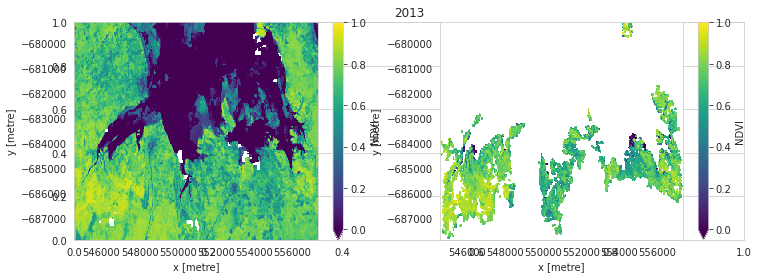

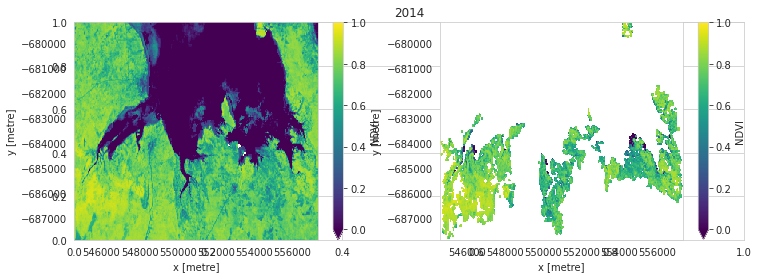

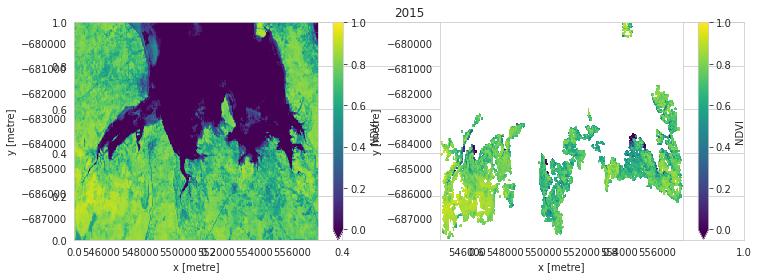

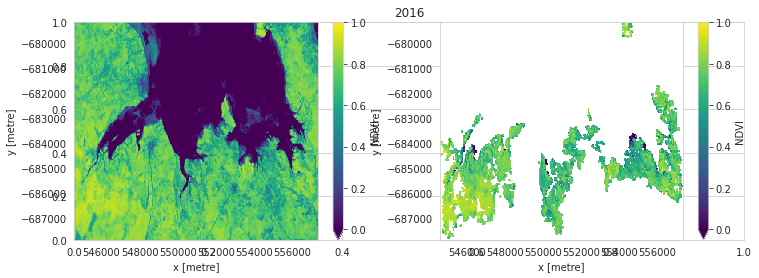

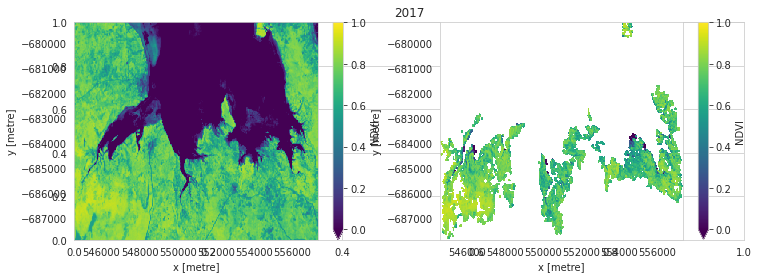

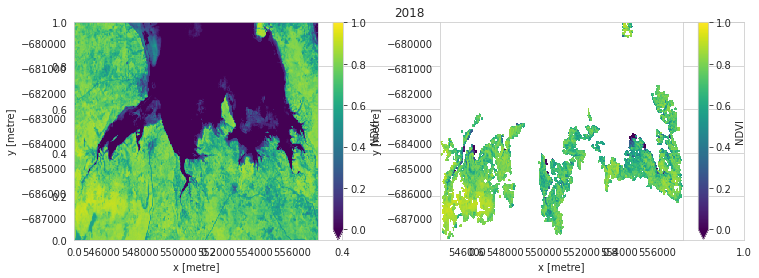

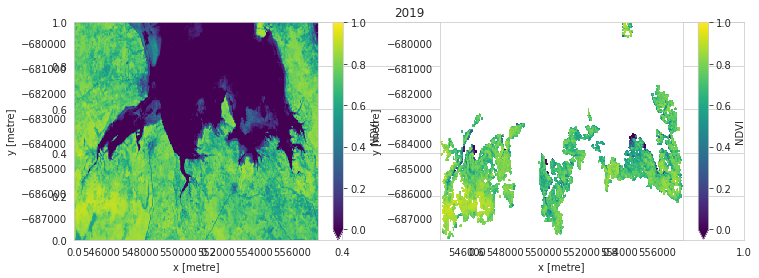

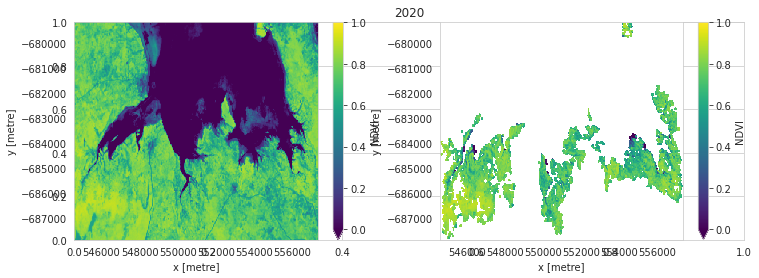

In [29]:
# fig = plt.figure(figsize=(12, 4))
# fig.add_subplot(121)
# ds_year_one_geomedian.built_index.plot(vmin=-0.50, vmax=0.8, cmap='RdYlGn')
# fig.add_subplot(122)
# ds_year_two_geomedian.built_index.plot(vmin=-0.50, vmax=0.8, cmap='viridis')


for images_year in images_years:
    fig = plt.figure(figsize=(12, 4))
    plt.title(str(images_year))
    fig.add_subplot(121)
    datacollection[images_year][0]['NDVI'].plot(vmin=0.0, vmax=1)
    fig.add_subplot(122)
    datacollection[images_year][1]['NDVI'].plot(vmin=0.0, vmax=1)
    

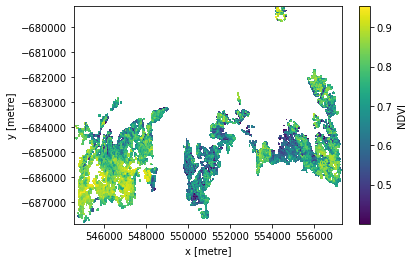

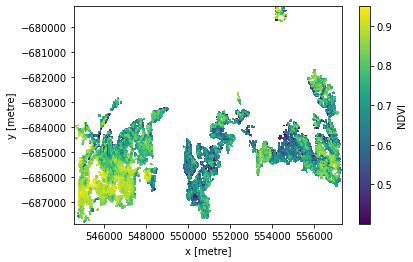

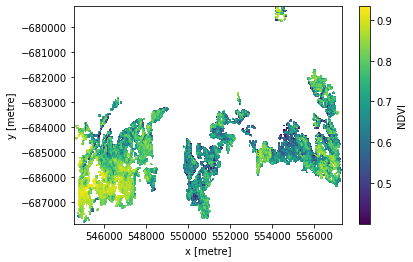

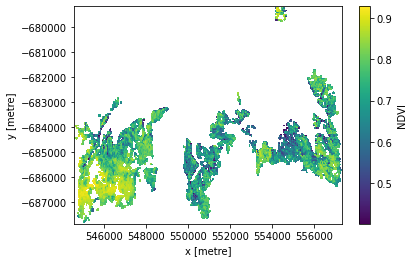

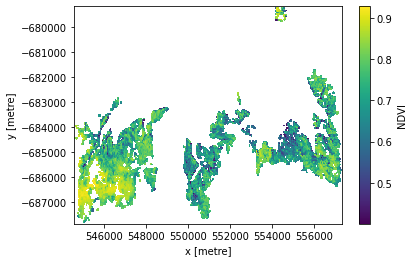

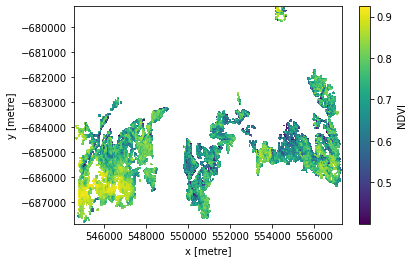

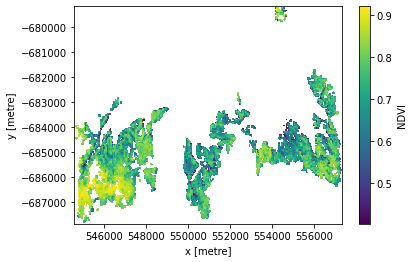

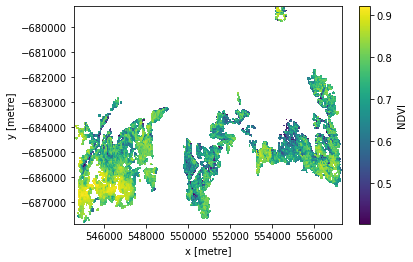

In [9]:
for images_year in images_years:
    datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.4).plot(size=4)

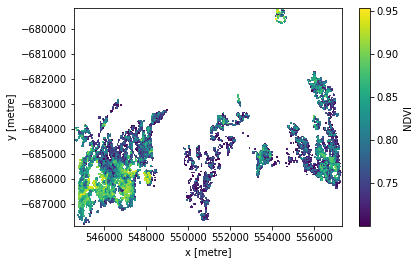

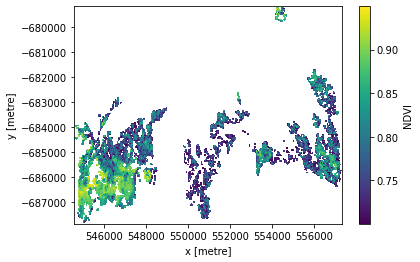

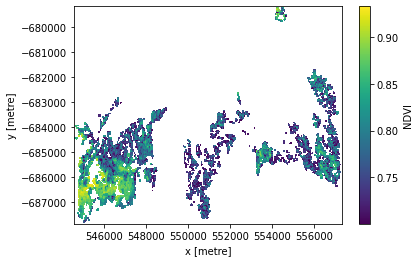

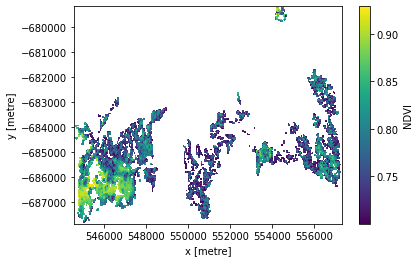

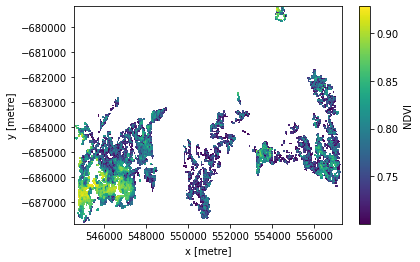

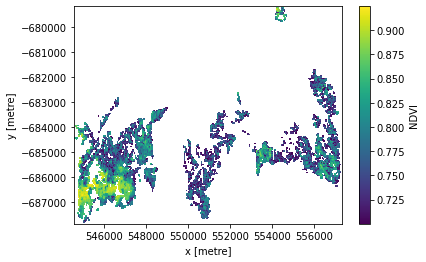

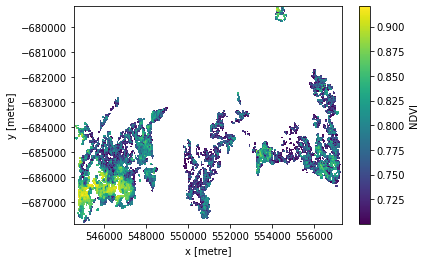

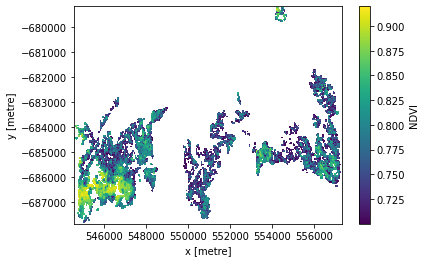

In [10]:
for images_year in images_years:
    datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]
                                                 ['NDVI'] > 0.7).plot(size=4)

Text(0.5, 1.0, 'Open Mangroves in 2020')

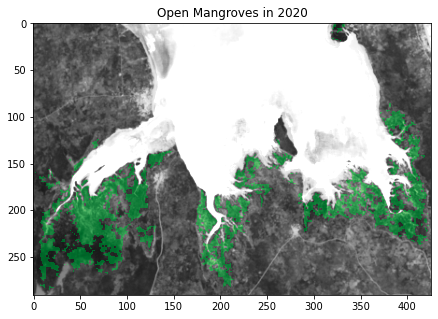

In [11]:
#Open Mangroves
current_year = images_years[-1]
plt.figure(figsize=(12, 5))
plt.imshow(datacollection[images_year][0]['NDVI'], cmap='Greys', vmin=0,vmax=1)
plt.imshow(datacollection[images_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.4), cmap='Greens',  vmin=0,vmax=1)
plt.title('Open Mangroves in ' + str(current_year))

Text(0.5, 1.0, 'Closed Mangroves in 2020')

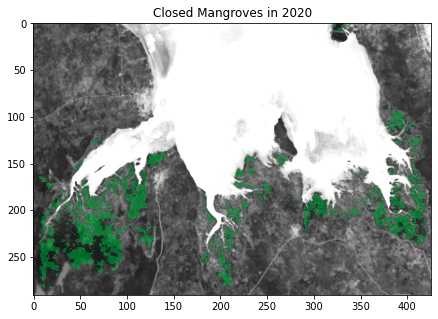

In [12]:
#Closed Mangroves
plt.figure(figsize=(12, 5))
plt.imshow(datacollection[current_year][0]['NDVI'], cmap='Greys', vmin=0,vmax=1)
plt.imshow(datacollection[current_year][1]['NDVI'].where(datacollection[current_year][1]['NDVI'] > 0.7), cmap='BuGn',  vmin=0,vmax=1)
plt.title('Closed Mangroves in ' + str(current_year))

In [13]:
closed_mangrove = {}
open_mangrove = {}
for images_year in images_years:
    closed_mangrove[images_year] = datacollection[images_year][1].where(datacollection[images_year][1]['NDVI'] > 0.7).count(dim=['x','y']).NDVI.values.sum()
    open_mangrove[images_year] = datacollection[images_year][1].where(datacollection[images_year][1]['NDVI'] > 0.4).count(dim=['x','y']).NDVI.values.sum()

In [14]:
df = pd.DataFrame(open_mangrove, index=['All Mangrove Count']).append(pd.DataFrame(closed_mangrove,index=['Closed Mangrove Count']))
df

,2013,2014,2015,2016,2017,2018,2019,2020
All Mangrove Count,17635,18000,18030,18035,18029,18047,18054,18054
Closed Mangrove Count,12198,12902,12675,12702,12821,13073,13208,13236


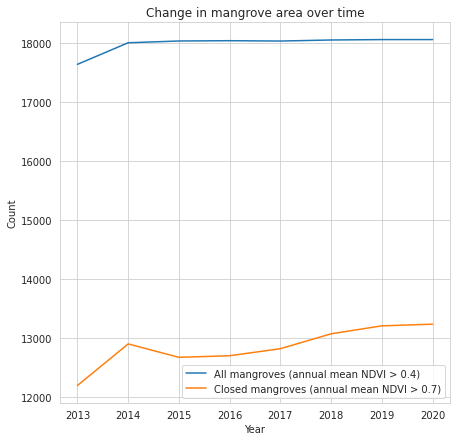

In [15]:
sns.set_style("whitegrid")

  

fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(images_years, list(open_mangrove.values()), label='All mangroves (annual mean NDVI > {})'.format(0.4))
ax.plot(images_years, list(closed_mangrove.values()), label='Closed mangroves (annual mean NDVI > 0.7)')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Change in mangrove area over time')
plt.xlabel('Year')
plt.ylabel('Count')

plt.legend()

plt.show()

## Change in Mangroves
The following plot shows the change in pixel counts that correspond to a mangrove classification by means of the NDVI threshold.

## Mangroves Mapped
### All Mangroves for Chosen Year
The following image shows all the detected mangroves for the chosen year. Default selection is the last year in the selected range of years (YEARS[-1]).

Text(0.5, 1.0, 'Open Mangroves in 2020')

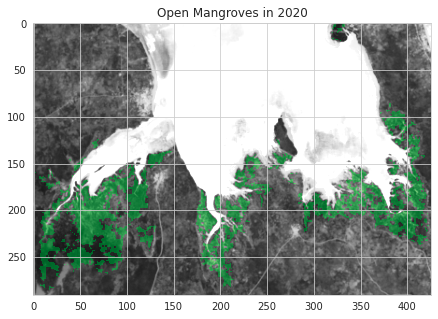

In [16]:
current_year = images_years[-1]
plt.figure(figsize=(12, 5))
plt.imshow(datacollection[current_year][0]['NDVI'], cmap='Greys', vmin=0,vmax=1)
plt.imshow(datacollection[current_year][1]['NDVI'].where(datacollection[current_year][1]['NDVI'] > 0.4), cmap='Greens',  vmin=0,vmax=1)
plt.title('Open Mangroves in ' + str(current_year))

### Closed Mangroves for Chosen Year
The following image is the same as the first, but highlights closed mangroves (with NDVI > 0.7).

* Green - Closed Mangroves
* OrRd - Other Mangroves

Text(0.5, 1.0, 'Mangroves in 2020')

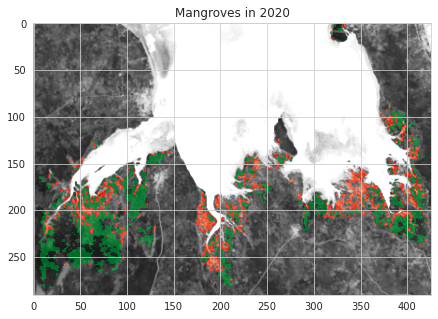

In [17]:
#Closed Mangroves
plt.figure(figsize=(12, 5))
plt.imshow(datacollection[current_year][0]['NDVI'], cmap='Greys', vmin=0,vmax=1)
plt.imshow(datacollection[current_year][1]['NDVI'].where(datacollection[images_year][1]['NDVI'] > 0.4), cmap='OrRd',  vmin=0,vmax=1)
plt.imshow(datacollection[current_year][1]['NDVI'].where(datacollection[current_year][1]['NDVI'] > 0.7), cmap='Greens',  vmin=0,vmax=1)
plt.title('Mangroves in ' + str(current_year))

### Change in Mangroves
The following image shows the change in mangroves between two selected years. Default selection is the oldest year and the year chosen above (YEARS[0], YEAR).

* Green - New Mangroves
* White - No Change
* Red - Loss of Mangroves

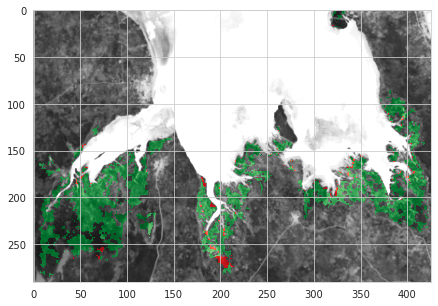

In [80]:
# # Select the year range here (ex: TIME = (2010, 2016)).
TIME = (images_years[0], current_year)

old_mangrove =  datacollection[TIME[0]][1].where(datacollection[images_year][1]['NDVI'] > 0.4) #.count(dim=['x','y']).NDVI.values.sum()
new_mangrove =  datacollection[TIME[1]][1].where(datacollection[images_year][1]['NDVI'] > 0.4) #.count(dim=['x','y']).NDVI.values.sum()

# old = mangroves.sel(year=TIME[0] ).astype(int)
# new = mangroves.sel(year=TIME[-1]).astype(int)
change = new_mangrove - old_mangrove
change
# print(change.count(dim=['x','y']).values.sum())
# new_mangrove.where(change)


plt.figure(figsize=(12, 5))
plt.imshow(datacollection[current_year][0]['NDVI'], cmap='Greys', vmin=0,vmax=1)


plt.imshow(datacollection[TIME[1]][1]['NDVI'].where(datacollection[TIME[1]][1]['NDVI'] > 0.4), cmap='Reds',  vmin=0,vmax=1)
plt.imshow(datacollection[TIME[0]][1]['NDVI'].where(datacollection[TIME[0]][1]['NDVI'] > 0.4), cmap='Greens',  vmin=0,vmax=1)

#### Pixel Counts

In [ ]:
# loss_count = datacollection[images_year][1].where(datacollection[images_year][1]['NDVI'] > 0.4).count(dim=['x','y']).NDVI.values.sum()
# gain_count = mangroves.sel(year=TIME[-1])['is_mangrove'].where(filtered_change == 1).sum()
# stable_count = mangroves.sel(year=TIME[-1])['is_mangrove'].where(filtered_change == 0).sum()

# # loss_count = mangroves.sel(year=TIME[0])['is_mangrove'].where(filtered_change == -1).sum()
# # gain_count = mangroves.sel(year=TIME[-1])['is_mangrove'].where(filtered_change == 1).sum()
# # stable_count = mangroves.sel(year=TIME[-1])['is_mangrove'].where(filtered_change == 0).sum()

# counts = {
#           'Loss of Mangroves': int(loss_count.item(0)),
#           'New Mangroves': int(gain_count.item(0)),
#           'No Change': int(stable_count.item(0)),
#           'Delta Change': int(gain_count.item(0) - loss_count.item(0))
#           }

# df = pd.DataFrame(counts, index=['Pixel Count'])
# print('Pixel Counts of Mangrove Changes Between the Years {} and {}:'.format(TIME[0], TIME[1]))
# df

In [ ]:
# df.plot.barh(color=['tab:red','tab:green','tab:orange','tab:blue'])